# Subset Landsat images of p012r030 with Sentinel-2 T19TCH bounding box

In [1]:
import sys

import numpy as np
from osgeo import gdal, gdal_array
import ogr, os, osr

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
typemap = {}
for name in dir(np):
    obj = getattr(np, name)
    if hasattr(obj, 'dtype'):
        try:
            npn = obj(0)
            nat = np.asscalar(npn)
            if gdal_array.NumericTypeCodeToGDALTypeCode(npn.dtype.type):
                typemap[npn.dtype.name] = gdal_array.NumericTypeCodeToGDALTypeCode(npn.dtype.type)
        except:
            pass

In [3]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,projstr,array):
    # newRasterfn (string): file name of created raster
    # rasterOrigin (list): [originX, originY], upper left corner of upper left pixel
    # pixelWidth, pixelHeight (float, scalar): pixel size in X and Y directions
    # projstr (string): string for projection, in OGC WKT or PROJ.4 format.
    # array (2D array, numeric): array to be written to the raster

    NP2GDAL_CONV = {
      "uint8": 1,
      "int8": 1,
      "uint16": 2,
      "int16": 3,
      "uint32": 4,
      "int32": 5,
      "float32": 6,
      "float64": 7,
      "complex64": 10,
      "complex128": 11,
    }
    
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    if array.dtype.name not in NP2GDAL_CONV.keys():
        print "GDAL raster does not support this data type: {0:s}".format(array.dtype.name)
        return
    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, NP2GDAL_CONV[array.dtype.name])
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
#     outRasterSRS = osr.SpatialReference()
#     outRasterSRS.ImportFromEPSG(4326) # WGS-84 datum
#     outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outRaster.SetProjection(projstr)
    outband.FlushCache()

In [7]:
def subset_image_with_bbox(img_fn, bbox, subset_img_fn, bnum=1):
    full_imgds = gdal.Open(img_fn)
    band1 = full_imgds.GetRasterBand(bnum)
    gt1 = full_imgds.GetGeoTransform()
    r1 = [gt1[0], gt1[3], gt1[0] + (gt1[1] * full_imgds.RasterXSize), gt1[3] + (gt1[5] * full_imgds.RasterYSize)]
    left1 = int(round((bbox[0]-r1[0])/gt1[1])) # difference divided by pixel dimension
    top1 = int(round((bbox[1]-r1[1])/gt1[5]))
    col1 = int(round((bbox[2]-r1[0])/gt1[1])) - left1 # difference minus offset left
    row1 = int(round((bbox[3]-r1[1])/gt1[5])) - top1
    if col1 < 0 or row1 < 0:
        print "Input image has no overlap with the given bounding box!\n"
        return
    else:
        array1 = band1.ReadAsArray(left1,top1,col1,row1)

    array2raster(subset_img_fn,[left1,top1],full_imgds.RasterXSize,full_imgds.RasterYSize,full_imgds.GetProjectionRef(),array1)

In [5]:
# bbox has left, top, right, bottom of dataset's bounds in geospatial coordinates.
bbox = [299955.0, 4800015.0, 409845.0, 4690215.0]

In [40]:
full_img_files = [ \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_band2.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_band3.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_band4.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_band5.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_band6.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_band7.tif' \
                 ]

In [41]:
for img_fn in full_img_files:
    subset_img_fn = "{0:s}_T19TCH_subset.tif".format(img_fn[0:img_fn.rfind('.')])
    subset_image_with_bbox(img_fn, bbox, subset_img_fn)

In [42]:
full_img_files = [ \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_sr_band2.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_sr_band3.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_sr_band4.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_sr_band5.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_sr_band6.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302015304LGN00/LC80120302015304LGN00_sr_band7.tif' \
                 ]

In [43]:
for img_fn in full_img_files:
    subset_img_fn = "{0:s}_T19TCH_subset.tif".format(img_fn[0:img_fn.rfind('.')])
    subset_image_with_bbox(img_fn, bbox, subset_img_fn)

(-0.5, 3662.5, 3659.5, -0.5)

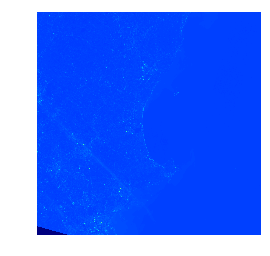

In [38]:
plt.imshow(array1)
plt.axis('off')

In [7]:
full_img_files = [ \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302016003LGN00/LC80120302016003LGN00_toa_band2.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302016003LGN00/LC80120302016003LGN00_toa_band3.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302016003LGN00/LC80120302016003LGN00_toa_band4.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302016003LGN00/LC80120302016003LGN00_toa_band5.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302016003LGN00/LC80120302016003LGN00_toa_band6.tif', \
'/neponset/nbdata06/albedo/zhan.li/landsat-8/LC80120302016003LGN00/LC80120302016003LGN00_toa_band7.tif' \
                 ]

In [8]:
for img_fn in full_img_files:
    subset_img_fn = "{0:s}_T19TCH_subset.tif".format(img_fn[0:img_fn.rfind('.')])
    subset_image_with_bbox(img_fn, bbox, subset_img_fn)

In [11]:
landsat_albedo_file = '/neponset/nbdata06/albedo/zhan.li/landsat-8/landsat-8-albedo/LC80120302015304LGN00/lndAlbedo_P012R030_2015-304'
subset_image_with_bbox(landsat_albedo_file, bbox, "{0:s}_bsa_T19TCH_subset.tif".format(landsat_albedo_file), bnum=1)
subset_image_with_bbox(landsat_albedo_file, bbox, "{0:s}_wsa_T19TCH_subset.tif".format(landsat_albedo_file), bnum=2)

In [10]:
"{0:s}_wsa_T19TCH_subset.tif".format(landsat_albedo_file[0:landsat_albedo_file.rfind('.')])

'/neponset/nbdata06/albedo/zhan_wsa_T19TCH_subset.tif'